<a href="https://colab.research.google.com/github/peterbabulik/QuantumPyTorch-Differentiable-Quantum-Circuits/blob/main/QuantumPyTorchGates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Building the Quantum Gate Zoo in PyTorch ---

--- Running IDEAL (Noiseless) Grover's Search for |11> ---

--- Running NOISY Grover's Search ---


Noisy Runs:   0%|          | 0/200 [00:00<?, ?it/s]

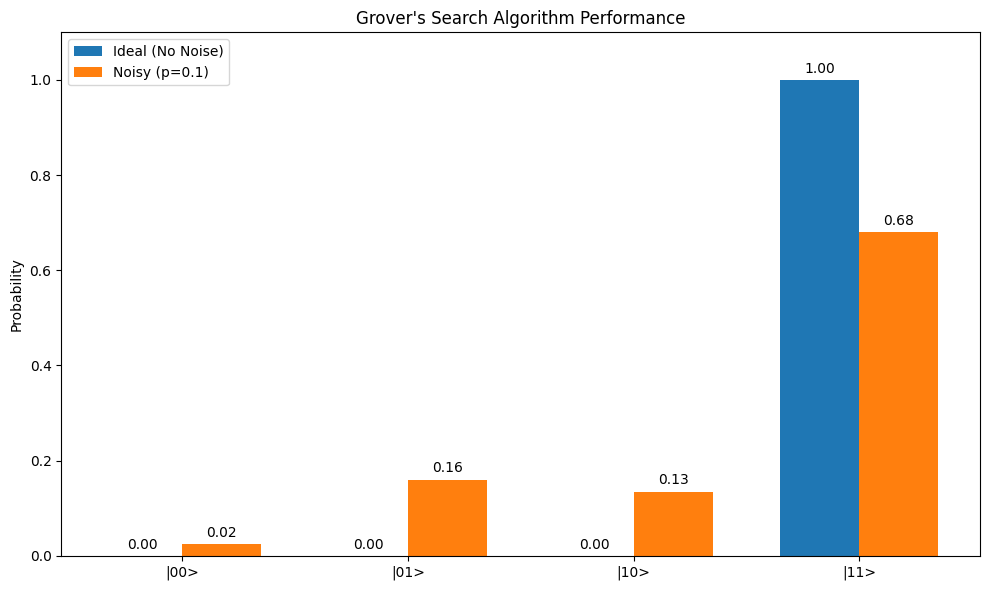


Ideal probability of finding marked item |11>: 1.0000
Noisy probability of finding marked item |11>: 0.6800


In [2]:
import torch
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import math

# ==============================================================================
# PART 1: The Quantum Gate Zoo (Implemented in PyTorch)
# ==============================================================================
print("--- Building the Quantum Gate Zoo in PyTorch ---")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Pauli Gates ---
I = torch.eye(2, dtype=torch.cfloat, device=device)
X = torch.tensor([[0, 1], [1, 0]], dtype=torch.cfloat, device=device) # Pauli-X (NOT)
Y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.cfloat, device=device) # Pauli-Y
Z = torch.tensor([[1, 0], [0, -1]], dtype=torch.cfloat, device=device) # Pauli-Z

# --- Other Essential Single-Qubit Gates ---
H = (1/math.sqrt(2)) * torch.tensor([[1, 1], [1, -1]], dtype=torch.cfloat, device=device) # Hadamard
S = torch.tensor([[1, 0], [0, 1j]], dtype=torch.cfloat, device=device) # Phase gate
# THIS IS THE CORRECTED LINE:
T = torch.tensor([[1, 0], [0, torch.exp(torch.tensor(1j * torch.pi / 4))]], dtype=torch.cfloat, device=device) # T-gate

def get_full_system_operator(op, i, num_qubits):
    """Creates the matrix for a single-qubit op acting on qubit 'i'."""
    op_list = [I] * num_qubits
    op_list[i] = op
    full_op = op_list[0]
    for k in range(1, num_qubits):
        full_op = torch.kron(full_op, op_list[k])
    return full_op

def get_controlled_operator(control_qubit, target_qubit, op, num_qubits):
    """Creates a controlled version of any single-qubit operator 'op'."""
    dim = 2**num_qubits
    P0 = torch.tensor([[1, 0], [0, 0]], dtype=torch.cfloat, device=device)
    P1 = torch.tensor([[0, 0], [0, 1]], dtype=torch.cfloat, device=device)

    # Term 1: Control is |0>, do nothing to target
    term1_list = [I] * num_qubits
    term1_list[control_qubit] = P0
    term1 = term1_list[0]
    for k in range(1, num_qubits): term1 = torch.kron(term1, term1_list[k])

    # Term 2: Control is |1>, apply operator to target
    term2_list = [I] * num_qubits
    term2_list[control_qubit] = P1
    term2_list[target_qubit] = op
    term2 = term2_list[0]
    for k in range(1, num_qubits): term2 = torch.kron(term2, term2_list[k])

    return term1 + term2

def get_mcz_operator(num_qubits):
    """Creates a Multi-Controlled Z gate where all qubits but the last are controls."""
    dim = 2**num_qubits
    mcz = torch.eye(dim, dtype=torch.cfloat, device=device)
    mcz[-1, -1] = -1 # Flips the phase of the |11...1> state
    return mcz

# ==============================================================================
# PART 2: Grover's Search Algorithm
# ==============================================================================
# Goal: Find the "marked" state |11> in a 2-qubit system.
N = 2
dim = 2**N
marked_item_binary = '11'
marked_item_int = int(marked_item_binary, 2)

# --- 2.1 The Grover Oracle ---
# The oracle "marks" the item we're looking for by flipping its phase.
# This is a diagonal matrix with a -1 at the position of the marked item.
oracle = torch.eye(dim, dtype=torch.cfloat, device=device)
oracle[marked_item_int, marked_item_int] = -1

# --- 2.2 The Grover Diffuser ---
# This operator amplifies the amplitude of the marked state.
# It can be constructed as H_all -> X_all -> MCZ -> X_all -> H_all

# Apply Hadamard to all qubits
H_all = H
for _ in range(N - 1): H_all = torch.kron(H_all, H)

# Apply X to all qubits
X_all = X
for _ in range(N - 1): X_all = torch.kron(X_all, X)

# Multi-Controlled Z gate
mcz = get_mcz_operator(N)

# Diffuser Operator
diffuser = H_all @ X_all @ mcz @ X_all @ H_all

# ==============================================================================
# PART 3: Run the Simulation (Noiseless vs. Noisy)
# ==============================================================================

# --- 3.1 Noiseless Simulation ---
print(f"\n--- Running IDEAL (Noiseless) Grover's Search for |{marked_item_binary}> ---")
# 1. Start in |00...0>
psi_ideal = torch.zeros(dim, dtype=torch.cfloat, device=device)
psi_ideal[0] = 1

# 2. Go to uniform superposition
psi_ideal = H_all @ psi_ideal

# 3. Apply Grover operator (Oracle + Diffuser). For N=2, one iteration is optimal.
psi_ideal = diffuser @ oracle @ psi_ideal

# 4. Measure the outcome probabilities
probabilities_ideal = torch.abs(psi_ideal)**2

# --- 3.2 Noisy Simulation ---
print("\n--- Running NOISY Grover's Search ---")
p_noise = 0.10 # 10% error rate - quite high to see a clear effect
num_runs = 200 # Average over many runs

def apply_state_noise(psi, p_noise):
    """Applies a random Pauli error to each qubit of a statevector."""
    for i in range(N):
        if torch.rand(1).item() < p_noise:
            error_op = get_full_system_operator(random.choice([X, Z]), i, N)
            psi = error_op @ psi
    return psi

final_probabilities_noisy_sum = torch.zeros(dim, device=device)

for _ in tqdm(range(num_runs), desc="Noisy Runs"):
    # 1. Start in |00>
    psi_noisy = torch.zeros(dim, dtype=torch.cfloat, device=device)
    psi_noisy[0] = 1

    # 2. Go to superposition
    psi_noisy = H_all @ psi_noisy
    psi_noisy = apply_state_noise(psi_noisy, p_noise) # Noise after H_all

    # 3. Apply Oracle
    psi_noisy = oracle @ psi_noisy
    psi_noisy = apply_state_noise(psi_noisy, p_noise) # Noise after Oracle

    # 4. Apply Diffuser
    psi_noisy = diffuser @ psi_noisy
    psi_noisy = apply_state_noise(psi_noisy, p_noise) # Noise after Diffuser

    final_probabilities_noisy_sum += torch.abs(psi_noisy)**2

# Average the results
probabilities_noisy = final_probabilities_noisy_sum / num_runs


# ==============================================================================
# PART 4: Plot and Analyze the Results
# ==============================================================================
labels = [f'|{i:0{N}b}>' for i in range(dim)]
x = torch.arange(dim)
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, probabilities_ideal.cpu().numpy(), width, label='Ideal (No Noise)')
rects2 = ax.bar(x + width/2, probabilities_noisy.cpu().numpy(), width, label=f'Noisy (p={p_noise})')

ax.set_ylabel('Probability')
ax.set_title("Grover's Search Algorithm Performance")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.1)
ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

fig.tight_layout()
plt.show()

print(f"\nIdeal probability of finding marked item |{marked_item_binary}>: {probabilities_ideal[marked_item_int].item():.4f}")
print(f"Noisy probability of finding marked item |{marked_item_binary}>: {probabilities_noisy[marked_item_int].item():.4f}")